In [ ]:
!git clone https://github.com/NoSleepDeveloper/ass3_appliedML.git
!unzip /content/ass3_appliedML/Ass3.zip

Cloning into 'ass3_appliedML'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.
Archive:  /content/ass3_appliedML/Ass3.zip
   creating: Ass3/
   creating: Ass3/data/
  inflating: Ass3/data/ass3.pickle   
  inflating: Ass3/model.py           
  inflating: Ass3/test.py            


In [3]:
!pip install optuna
!pip install lazypredict

     |████████████████████████████████| 14.5 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 127.6 MB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 25.8 MB 23.0 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 302 kB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 374 kB/s eta 0:00:011
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.39.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.19.1 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.6.0 which is incompatible.
ERROR: tensorflow-gpu 2.6.0 has requirement numpy~=1.19.2, but you'll have numpy 1.19.1 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
     

In [4]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import optuna
from optuna.samplers import TPESampler

import lazypredict
from lazypredict.Supervised import LazyRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler


from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.kernel_ridge import KernelRidge

In [5]:
with open('Ass3/data/ass3.pickle', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train = data['train']
X_dev, y_dev = data['dev']



In [6]:
print(f'y_train type={y_train.dtype}')
print(f'y_train min={min(y_train)}')
print(f'y_train max={max(y_train)}')
print(f'y_dev type={y_dev.dtype}')
print(f'y_dev min={min(y_dev)}')
print(f'y_dev max={max(y_dev)}')

y_train type=float64
y_train min=-21.822222222222226
y_train max=39.58888888888889
y_dev type=float64
y_dev min=-20.555555555555557
y_dev max=38.84444444444445


And this time it is indeed a regression problem

In [6]:
X_train_pd = pd.DataFrame(data=X_train, columns=[f'f{i}' for i in range(len(X_train[0]))])
X_dev_pd = pd.DataFrame(data=X_dev, columns=[f'f{i}' for i in range(len(X_dev[0]))])
y_train_pd = pd.Series(data=y_train, name='target')
y_dev_pd = pd.Series(data=y_dev, name='target')
trainData = X_train_pd.join(y_train_pd)
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48226 entries, 0 to 48225
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f0      48226 non-null  float64
 1   f1      48226 non-null  float64
 2   f2      48226 non-null  float64
 3   f3      48226 non-null  float64
 4   f4      48226 non-null  float64
 5   f5      48226 non-null  float64
 6   f6      48226 non-null  float64
 7   f7      48226 non-null  float64
 8   f8      48226 non-null  float64
 9   f9      48226 non-null  float64
 10  f10     48226 non-null  float64
 11  f11     48226 non-null  float64
 12  f12     48226 non-null  float64
 13  target  48226 non-null  float64
dtypes: float64(14)
memory usage: 5.2 MB


from the above output we can see that our data doesn't have empty fields ( non - null )

In [ ]:
trainData.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,target
count,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00,48226.00
mean,16.00,0.11,0.74,10.82,187.29,10.35,0.00,1003.93,129.23,15.72,6.51,2011.01,11.50,11.91
std,4.36,0.33,0.20,6.91,107.55,4.20,0.00,113.99,56.27,8.80,3.45,3.16,6.94,9.54
min,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,2006.00,0.00,-21.82
25%,17.00,0.00,0.60,5.83,114.00,8.31,0.00,1011.91,95.00,8.00,4.00,2008.00,5.00,4.59
50%,18.00,0.00,0.78,9.98,180.00,10.05,0.00,1016.44,118.00,16.00,7.00,2011.00,11.00,11.99
75%,19.00,0.00,0.90,14.14,290.00,14.86,0.00,1021.10,181.00,23.00,10.00,2014.00,18.00,18.84
max,26.00,1.00,1.00,55.93,359.00,16.10,0.00,1046.26,213.00,31.00,12.00,2016.00,23.00,39.59


We see that f6 min and max are 0, and so the whole feature data is 0 and we can ignore this feature

In [7]:
trainData = trainData.drop(columns=["f6"])
X_train = X_train_pd.drop(columns=["f6"])
X_dev = X_dev_pd.drop(columns=["f6"])

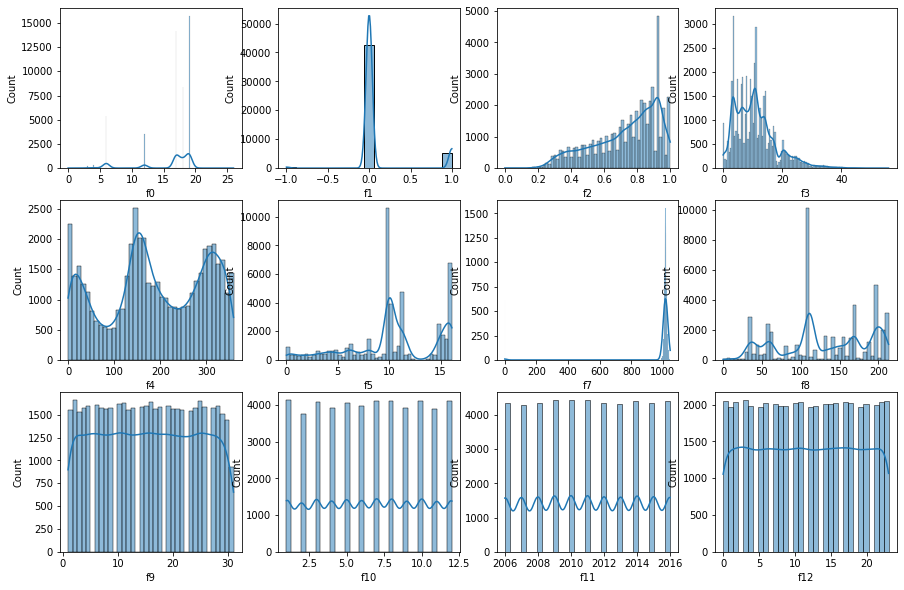

In [ ]:
# feature analysis
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for class_i,feature in enumerate(trainData.columns[:-1]):
  sns.histplot(data = trainData, x = feature, kde = True ,ax=ax[(class_i) // 4, (class_i) % 4] )
plt.show()

We see intersting histograms in features f1,f7 and f11.
So we will analyze it more thoroughly.

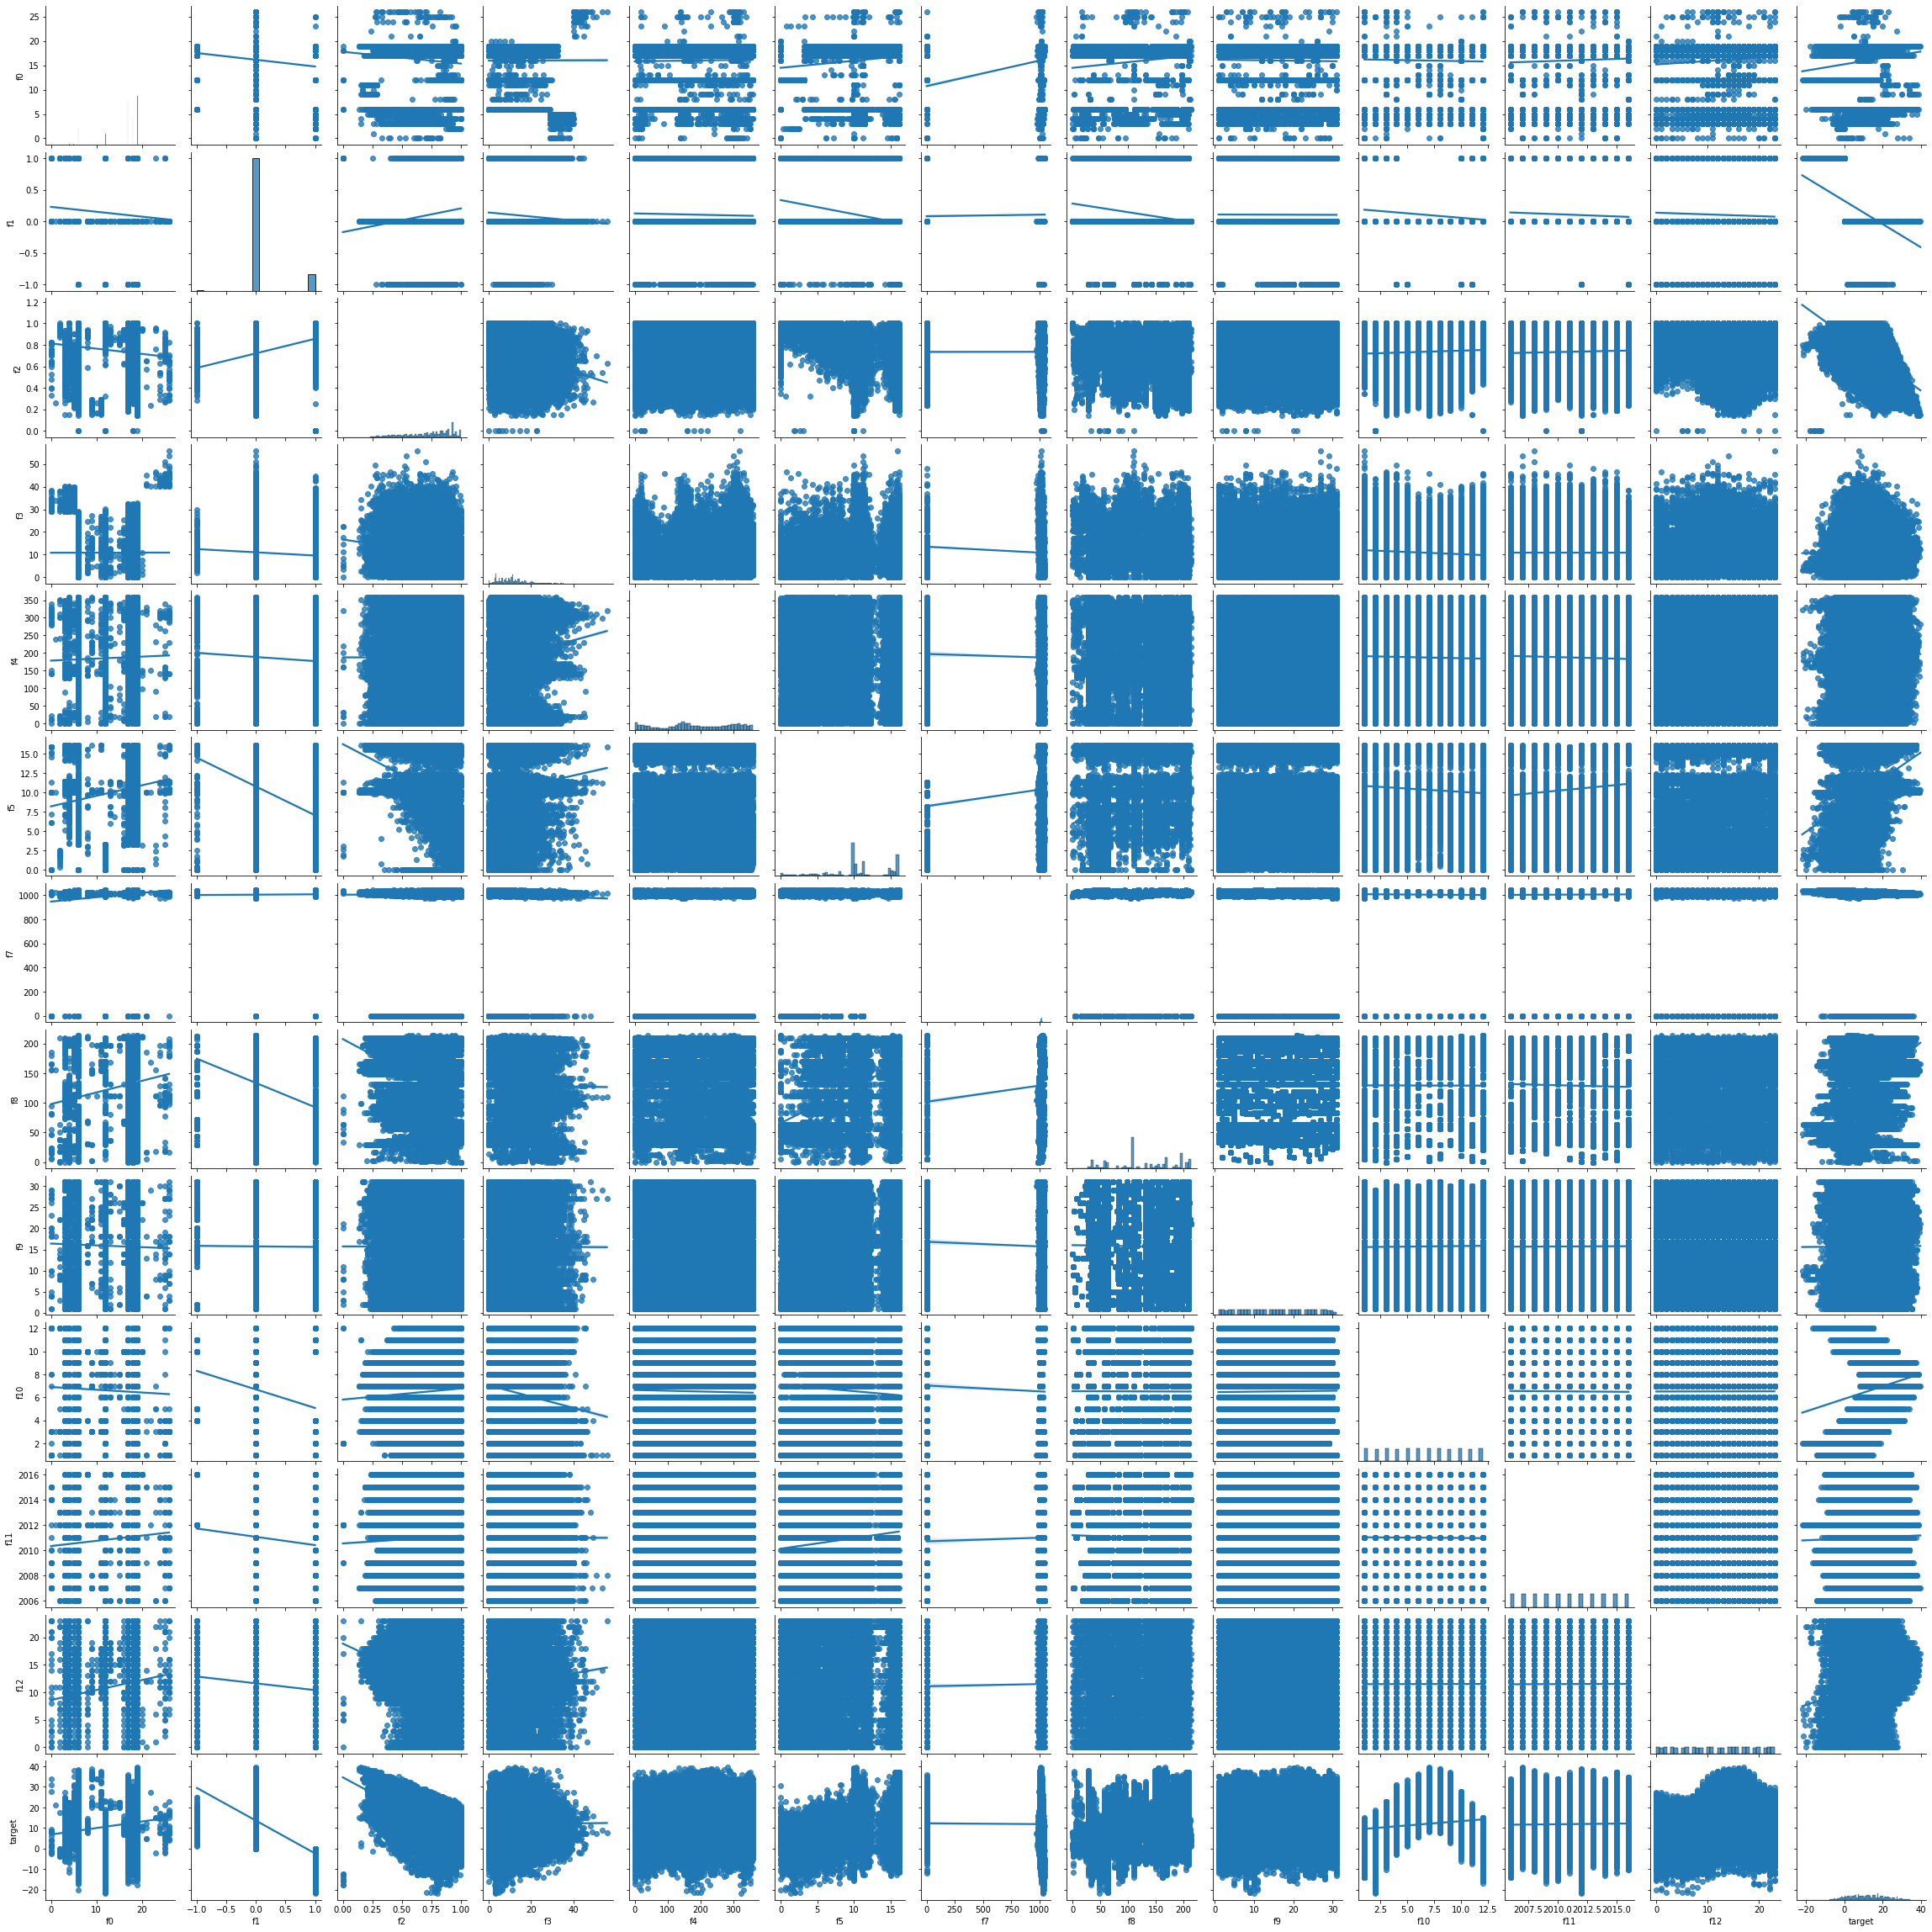

In [ ]:
sns.pairplot(trainData, kind="reg")

We didn't nootice any meaningful correlations in the pair-plot above.

611
611


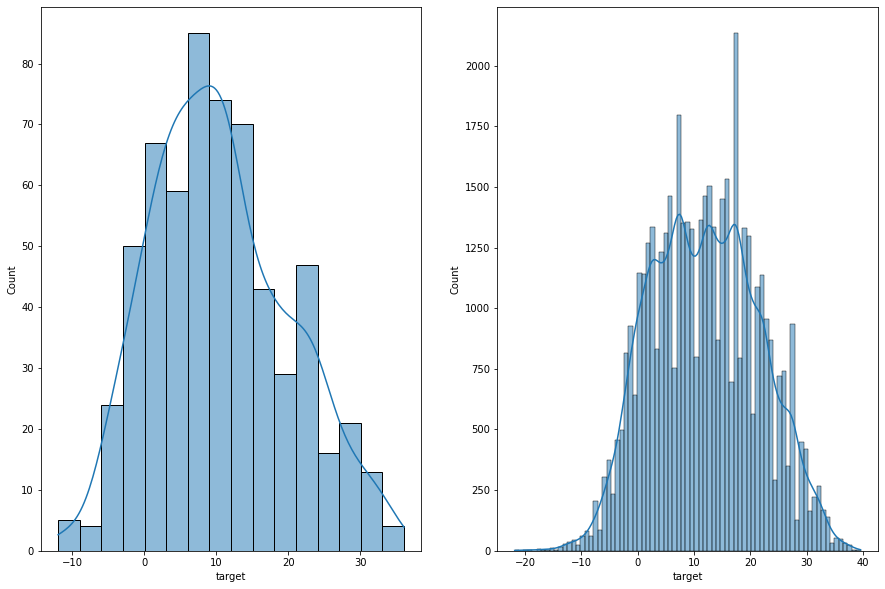

In [ ]:
print(trainData['f7'][trainData['f7'] == 0].count())
print(trainData['f7'][trainData['f7'] < 950].count())
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sns.histplot(data = trainData[trainData.f7 == 0], x = 'target', kde = True, ax=ax[0])
sns.histplot(data = trainData[trainData.f7 != 0], x = 'target', kde = True, ax=ax[1])

We see that all valuse except 611 samples are greater than 950 and are dense around 1K. 
plotting targets histogram vs. f7, we see that the distribution for zero values and non-zero values f7 values are close, and so we infer that 0 values are like nulls - bad samples, that could be ignored.
To clean the null values, we will replace them with the median value of the feature.
 We use this method to not lose data.
 <!-- https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/ -->
 We remember that this method can impute the approximations add variance and bias

In [8]:
trainData['f7'].replace(to_replace = 0,value = trainData['f7'].median(),inplace=True)
X_train['f7'].replace(to_replace = 0,value = X_train['f7'].median(),inplace=True)
X_dev['f7'].replace(to_replace = 0,value = X_dev['f7'].median(),inplace=True)

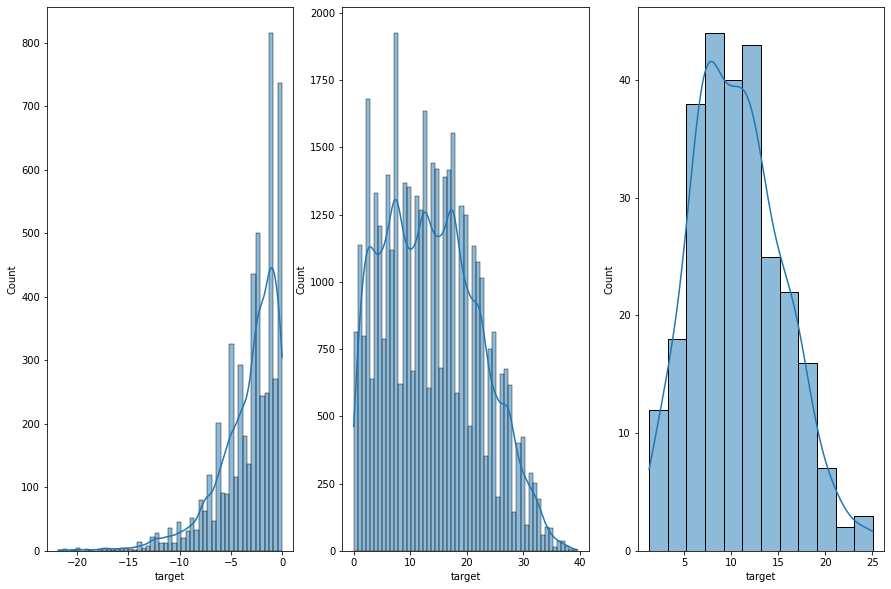

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.histplot(data = trainData[trainData.f1 == 1], x = 'target', kde = True, ax=ax[0])
sns.histplot(data = trainData[trainData.f1 == 0], x = 'target', kde = True, ax=ax[1])
sns.histplot(data = trainData[trainData.f1 == -1], x = 'target', kde = True, ax=ax[2])

Looking into f1, we can't find indication for bad samples, and so we leave the data as is, remebering that non-zero values are significant for this feature, and can impact the prediction of the model a lot.

26343
21883


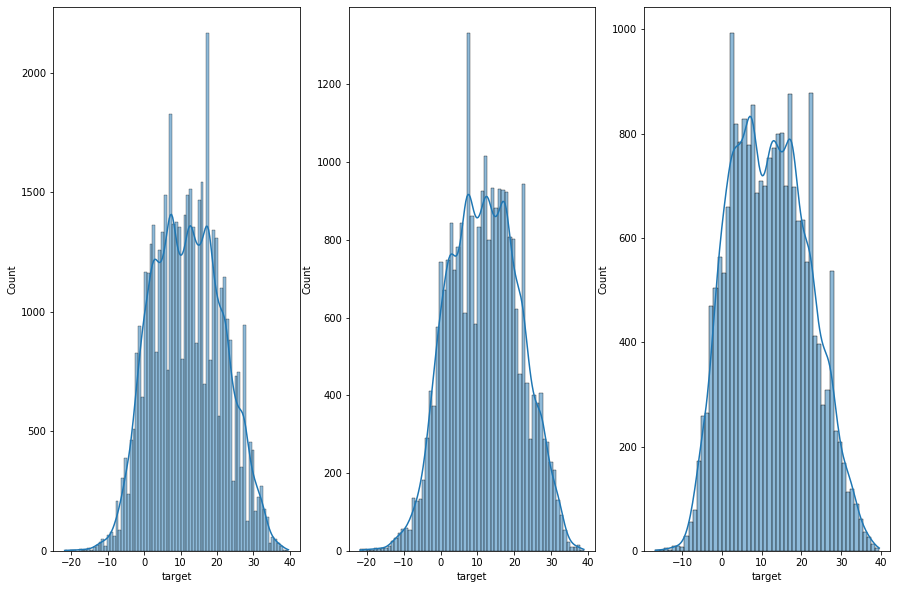

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
print(trainData['f11'][trainData.f11 % 2 == 0].count())
print(trainData['f11'][trainData.f11 % 2 != 0].count())
sns.histplot(data = trainData, x = 'target', kde = True, ax=ax[0])
sns.histplot(data = trainData[trainData.f11 % 2 == 0], x = 'target', kde = True, ax=ax[1])
sns.histplot(data = trainData[trainData.f11 % 2 != 0], x = 'target', kde = True, ax=ax[2])

We see that f11 contains int values between 2006 and 2016. We infer this values represents years, and see in closer look, that the distribution over evan and odd years is similar, and the original histplot is confusing beacuase of seaborn converting the axis to floats.

Hypotesis - f9 is between 1-31, and f10 is between 1-12, it might be day and month (correlating to f11 - year). Since we're not sure, we will not use this hypotesis when training the model.

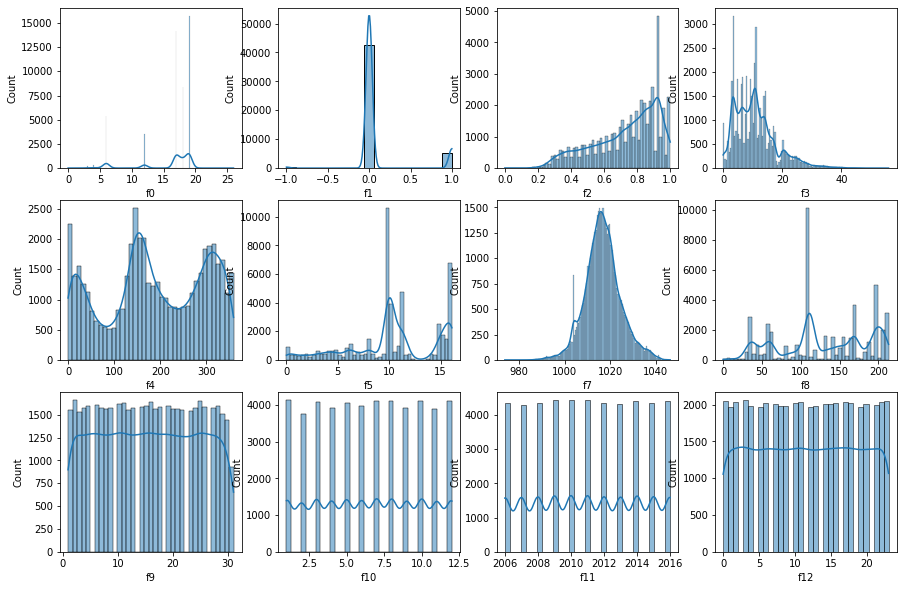

In [ ]:
# feature analysis
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for class_i,feature in enumerate(trainData.columns[:-1]):
  sns.histplot(data = trainData, x = feature, kde = True ,ax=ax[(class_i) // 4, (class_i) % 4] )
plt.show()

We will now use Pandas corr fuction to see correlation between features and the target.

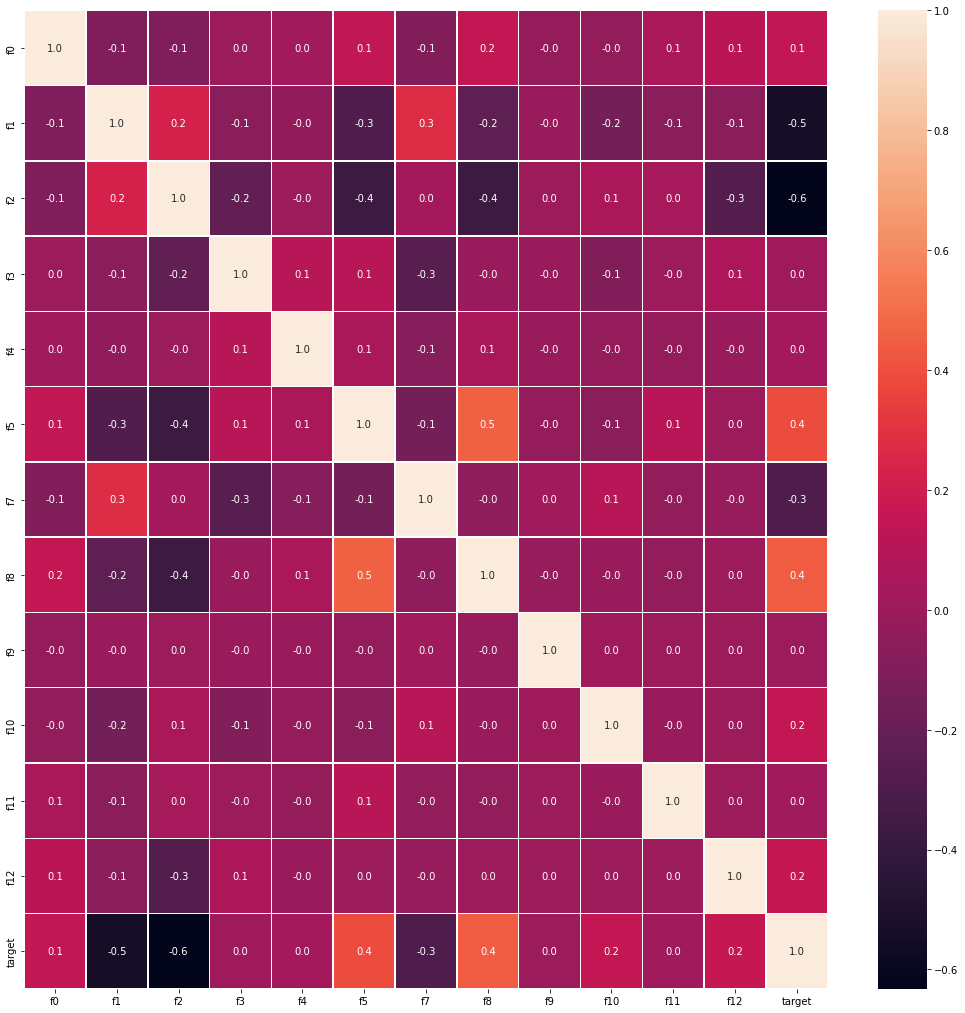

In [ ]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(trainData.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

There are no strong correlation between features, means that there are no strong relationships. That's why we won't remove any information.
We see relatively strong connection between f2 and the target, which we might take to consideration when training the model

In [ ]:
scalers = {
  "std":  StandardScaler(),
  "qt":   QuantileTransformer(),
  "pt":   PowerTransformer(),
  "mm":   MinMaxScaler(),
  "norm": Normalizer()
}

for name, scaler in scalers.items():
  clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric="neg_mean_absolute_error")
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_dev_scaled = scaler.transform(X_dev)
  models,predictions = clf.fit(X_train_scaled, X_dev_scaled, y_train, y_dev)
  print(f"\n {name}'s results are: \n")
  print(models.sort_values(['R-Squared','Adjusted R-Squared'],ascending=False).iloc[:3])

  
  

Running the above code in Jupiter lab caused the machine to terminate, and so we left a sample of the run from the notebook run, and attached below the output for this code, ran on our local machine, organized in a compact table.

| Model                 | std scaler | qt scaler | pt scaler | mm scaler | rb scaler | norm scaler |
|-----------------------|------------|-----------|-----------|-----------|-----------|-------------|
| ExtraTreesRegressor   | 1.24       | 1.25      | 1.23      | 1.24      | 1.24      | 1.49        |
| RandomForestRegressor | 1.40       | 1.40      | 1.40      | 1.40      | 1.40      | 1.65        |
| BaggingRegressor      | 1.50       | 1.50      | 1.50      | 1.50      | 1.50      | 1.74        |

From the code above we saw that the top 3 models that brought us to the lowest error with constistancy across different scalers were: 

1) ExtraTreesRegressor  

2) RandomForestRegressor 

3) BaggingRegressor 

Althogh RidgeKernelRegressor wasn't one of the top results in the LazyRegressor, We will try to train it with Optuna, because as we saw in Prof. Sipper article, hyper-parameter tuning is very significant for this regressor, and so the lazy results for it, using the default hyper-parameters, is not reliable.
The rest of the models, will be the top performing models from LazyRegressor.

For the hyper-parameter tuning, we will use both the train and the dev to have more data, and more accurate model.
We will save the original train and dev to test our model after we're done with the hyper-parameter tuning.

In [9]:
X_train_orig = X_train.copy()
y_train_orig = y_train.copy()
X_train = X_train.append(X_dev)
y_train = y_train_pd.append(y_dev_pd)

In [21]:
def objective(trial):
  regressor_name = trial. suggest_categorical("regressor", ["ExtraTreesRegressor", "RandomForest", "Bagging"]) # "KernelRidge"
  scaler_name = trial. suggest_categorical("scaler", ["StandardScaler", "PowerTransformer", "MinMaxScaler", "RobustScaler"])

  if regressor_name == "ExtraTreesRegressor":
    n_estimators = trial.suggest_int("ExtraTrees_n_estimators", 10, 200, log=True)
    criterion = trial.suggest_categorical("ExtraTrees_criterion", ["squared_error", "absolute_error"])
    max_features = trial.suggest_categorical("ExtraTrees_max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("ExtraTrees_bootstrap", [True, False])
    if bootstrap:
        max_samples = trial.suggest_float("ExtraTrees_max_samples", 0, 1)
    else:  # max samples is ignored
        max_samples = None
    random_state = trial.suggest_categorical("ExtraTrees_random_state", [0, 42])
    regressor_obj = ExtraTreesRegressor(n_estimators=n_estimators,
                                        criterion=criterion,
                                        max_features=max_features,
                                        bootstrap=bootstrap,
                                        max_samples=max_samples,
                                        random_state=random_state)

  # elif regressor_name == "KernelRidge":
  #   alpha = trial.suggest_float("alpha", 1e-10, 1, log=True)
  #   kernel = trial.suggest_categorical("kernel", pairwise.PAIRWISE_KERNEL_FUNCTIONS.keys())
  #   gamma = trial.suggest_float("gamma", 0.1, 200, log=True)
  #   degree = trial.suggest_int("degree", 1, 5)
  #   coef0 = trial.suggest_float("coef0", 1e-10, 5, log=True)
  #   regressor_obj = KernelRidge(alpha=alpha,
  #                               kernel=kernel,
  #                               gamma=gamma,
  #                               degree=degree,
  #                               coef0=coef0)
    
  elif regressor_name == "Bagging":
      n_estimators = trial.suggest_int("Bagging_n_estimators", 10, 200, log=True)
      max_features = trial.suggest_float("Bagging_max_features", 1e-10, 1, log=True)
      bootstrap = trial.suggest_categorical("Bagging_bootstrap", [True, False])
      bootstrap_features = trial.suggest_categorical("Bagging_bootstrap_features", [True, False])
      random_state = trial.suggest_categorical("Bagging_random_state", [0, 42])
      regressor_obj = BaggingRegressor(n_estimators=n_estimators,
                                        max_features=max_features,
                                        bootstrap=bootstrap,
                                        bootstrap_features=bootstrap_features,
                                        random_state=random_state)

  elif regressor_name == "RandomForest":
      n_estimators = trial.suggest_int("RandomForest_n_estimators", 10, 200, log=True)
      criterion = trial.suggest_categorical("RandomForest_criterion", ["squared_error", "absolute_error"]) #, "poisson"
      max_features = trial.suggest_categorical("RandomForest_max_features", ["sqrt", "log2", None])
      bootstrap = trial.suggest_categorical("RandomForest_bootstrap", [True, False])
      if bootstrap:
          max_samples = trial.suggest_float("RandomForest_max_samples", 0, 1)
      else:  # max samples is ignored
          max_samples = None
      random_state = trial.suggest_categorical("RandomForest_random_state", [0, 42])
      regressor_obj = RandomForestRegressor(n_estimators=n_estimators,
                                            criterion=criterion,
                                            max_features=max_features,
                                            bootstrap=bootstrap,
                                            max_samples=max_samples,
                                            random_state=random_state)

  else:
    exit('error: unknown Regressor')
  
  scaler = globals()[scaler_name]()
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_dev_scaled = scaler.transform(X_dev)
  score = cross_val_score(regressor_obj, X_train_scaled, y_train, n_jobs=None, cv=3, 
                          error_score=float('-inf'),
                          scoring="neg_mean_absolute_error")
  accuracy = score.mean()
  return accuracy


In [ ]:
study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_trials=100, n_jobs=-1)
print('best_trial\n', study.best_trial)
print('best_params\n', study.best_params)
print('best_value\n', study.best_value)

rg_name = study.best_params['regressor']
scaler_name = study.best_params['scaler']

hparams = {}
prefix = study.best_params['regressor']
for key, value in study.best_params.items():
  if key != 'regressor' and key != 'scaler': 
    new_key = key[len(prefix)+1:] 
    hparams[new_key] = value 
print(scaler_name, hparams)




[I 2022-07-02 14:44:28,061] A new study created in memory with name: no-name-1a599072-49fc-470f-8734-a4e52a9a82aa
/home/idanto/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-02 14:44:29,835] Trial 3 finished with value: -2.641154883843844 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 16, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.062333221906363034, 'ExtraTrees_random_state': 42}. Best is trial 3 with value: -2.641154883843844.
[I 2022-07-02 14:44:32,288] Trial 4 finished with value: -6.254039225971173 and parameters: {'regressor': 'Bagging', 'scaler': 'MinMaxScaler', 'Bagging_n_estimators': 25, 'Bagging_max_features': 1.7531048023

Running it in Jupiter lab caused the machine to terminate, and so we left a sample of the run from the notebook run, and attached below the output for this cose, ran on our local machine.

[I 2022-07-02 14:44:28,061] A new study created in memory with name: no-name-1a599072-49fc-470f-8734-a4e52a9a82aa
/home/idanto/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
warnings.warn(
[I 2022-07-02 14:44:29,835] Trial 3 finished with value: -2.641154883843844 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 16, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.062333221906363034, 'ExtraTrees_random_state': 42}. Best is trial 3 with value: -2.641154883843844.
[I 2022-07-02 14:44:32,288]  Trial 4 finished with value: -6.254039225971173 and parameters: {'regressor': 'Bagging', 'scaler': 'MinMaxScaler', 'Bagging_n_estimators': 25, 'Bagging_max_features': 1.753104802398546e-10, 'Bagging_bootstrap': False, 'Bagging_bootstrap_features': False, 'Bagging_random_state': 42}. Best is trial 3 with value: -2.641154883843844.
[I 2022-07-02 14:44:36,086]  Trial 9 finished with value: -2.2916914028962445 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 42, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.14603557126892963, 'ExtraTrees_random_state': 42}. Best is trial 9 with value: -2.2916914028962445.
[I 2022-07-02 14:44:38,860]  Trial 6 finished with value: -6.335751220861277 and parameters: {'regressor': 'Bagging', 'scaler': 'RobustScaler', 'Bagging_n_estimators': 68, 'Bagging_max_features': 0.08930423016376807, 'Bagging_bootstrap': False, 'Bagging_bootstrap_features': False, 'Bagging_random_state': 42}. Best is trial 9 with value: -2.2916914028962445.
[I 2022-07-02 14:44:40,636]  Trial 5 finished with value: -2.0157955821373243 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 76, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.3104081494234979, 'ExtraTrees_random_state': 0}. Best is trial 5 with value: -2.0157955821373243.
  [I 2022-07-02 14:44:46,944]  Trial 12 finished with value: -6.959237371978674 and parameters: {'regressor': 'Bagging', 'scaler': 'RobustScaler', 'Bagging_n_estimators': 15, 'Bagging_max_features': 2.1496331382586365e-08, 'Bagging_bootstrap': False, 'Bagging_bootstrap_features': True, 'Bagging_random_state': 42}. Best is trial 5 with value: -2.0157955821373243.
  [I 2022-07-02 14:44:47,205]  Trial 7 finished with value: -1.5596967002369577 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 38, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 7 with value: -1.5596967002369577.
  [I 2022-07-02 14:44:47,481]  Trial 1 finished with value: -1.5877906395608061 and parameters: {'regressor': 'RandomForest', 'scaler': 'PowerTransformer', 'RandomForest_n_estimators': 10, 'RandomForest_criterion': 'squared_error', 'RandomForest_max_features': None, 'RandomForest_bootstrap': True, 'RandomForest_max_samples': 0.6703228857785123, 'RandomForest_random_state': 42}. Best is trial 7 with value: -1.5596967002369577.
  [I 2022-07-02 14:44:57,109]  Trial 13 finished with value: -6.219954759633758 and parameters: {'regressor': 'Bagging', 'scaler': 'PowerTransformer', 'Bagging_n_estimators': 27, 'Bagging_max_features': 1.7596751892143455e-10, 'Bagging_bootstrap': True, 'Bagging_bootstrap_features': False, 'Bagging_random_state': 0}. Best is trial 7 with value: -1.5596967002369577.
  [I 2022-07-02 14:45:00,150]  Trial 11 finished with value: -1.8689529670333929 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 76, 'ExtraTrees_criterion': 'squared_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.5019838428321003, 'ExtraTrees_random_state': 0}. Best is trial 7 with value: -1.5596967002369577.
  [I 2022-07-02 14:45:01,388]  Trial 16 finished with value: -7.03796374135705 and parameters: {'regressor': 'Bagging', 'scaler': 'RobustScaler', 'Bagging_n_estimators': 20, 'Bagging_max_features': 2.324339822819659e-05, 'Bagging_bootstrap': True, 'Bagging_bootstrap_features': True, 'Bagging_random_state': 42}. Best is trial 7 with value: -1.5596967002369577.
  [I 2022-07-02 14:45:08,625]  Trial 0 finished with value: -1.4687446563401139 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 39, 'RandomForest_criterion': 'squared_error', 'RandomForest_max_features': 'sqrt', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 42}. Best is trial 0 with value: -1.4687446563401139.
  [I 2022-07-02 14:45:13,354]  Trial 18 finished with value: -1.861223731905895 and parameters: {'regressor': 'RandomForest', 'scaler': 'PowerTransformer', 'RandomForest_n_estimators': 10, 'RandomForest_criterion': 'squared_error', 'RandomForest_max_features': 'sqrt', 'RandomForest_bootstrap': True, 'RandomForest_max_samples': 0.7176822956899422, 'RandomForest_random_state': 42}. Best is trial 0 with value: -1.4687446563401139.
  [I 2022-07-02 14:45:58,892]  Trial 8 finished with value: -1.7398791821480897 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 177, 'RandomForest_criterion': 'squared_error', 'RandomForest_max_features': 'sqrt', 'RandomForest_bootstrap': True, 'RandomForest_max_samples': 0.5595960505011802, 'RandomForest_random_state': 0}. Best is trial 0 with value: -1.4687446563401139.
  [I 2022-07-02 15:04:24,707]  Trial 10 finished with value: -1.678019110897912 and parameters: {'regressor': 'ExtraTreesRegressor', 'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 10, 'ExtraTrees_criterion': 'absolute_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 42}. Best is trial 0 with value: -1.4687446563401139.
  [I 2022-07-02 16:42:47,048]  Trial 15 finished with value: -1.454012280061385 and parameters: {'regressor': 'RandomForest', 'scaler': 'RobustScaler', 'RandomForest_n_estimators': 39, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'log2', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 0}. Best is trial 15 with value: -1.454012280061385.
  [I 2022-07-02 17:13:27,646]  Trial 2 finished with value: -1.625005818562353 and parameters: {'regressor': 'RandomForest', 'scaler': 'PowerTransformer', 'RandomForest_n_estimators': 124, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'log2', 'RandomForest_bootstrap': True, 'RandomForest_max_samples': 0.9564690082373732, 'RandomForest_random_state': 0}. Best is trial 15 with value: -1.454012280061385.
  [I 2022-07-02 17:13:39,441]  Trial 21 finished with value: -1.4497316727870115 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 49, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'log2', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 42}. Best is trial 21 with value: -1.4497316727870115.
  [I 2022-07-02 18:19:10,191]  Trial 14 finished with value: -1.4306198479829355 and parameters: {'regressor': 'RandomForest', 'scaler': 'PowerTransformer', 'RandomForest_n_estimators': 76, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'sqrt', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 0}. Best is trial 14 with value: -1.4306198479829355.
  [I 2022-07-02 18:26:19,972]  Trial 19 finished with value: -1.4302621797222483 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 79, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'sqrt', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 0}. Best is trial 19 with value: -1.4302621797222483.
  [I 2022-07-02 18:47:46,810]  Trial 23 finished with value: -1.4507784886646178 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 47, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'log2', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 0}. Best is trial 19 with value: -1.4302621797222483.
  [I 2022-07-02 19:05:50,716]  Trial 25 finished with value: -1.4525993207710715 and parameters: {'regressor': 'RandomForest', 'scaler': 'MinMaxScaler', 'RandomForest_n_estimators': 42, 'RandomForest_criterion': 'absolute_error', 'RandomForest_max_features': 'log2', 'RandomForest_bootstrap': False, 'RandomForest_random_state': 0}. Best is trial 19 with value: -1.4302621797222483. \n"

Since KernelRidge required too many RAM resources, we sadly decided to waive it.
We found out that the best estimator is ExtraTreesRegressor, so we now try to optimize thoroughly with optuna only on that estimator.

In [1]:
def ExtraTreesobjective(trial):
  scaler_name = trial. suggest_categorical("scaler", ["StandardScaler", "PowerTransformer", "MinMaxScaler", "RobustScaler"])

  n_estimators = trial.suggest_int("ExtraTrees_n_estimators", 10, 100, log=True)
  criterion = trial.suggest_categorical("ExtraTrees_criterion", ["squared_error", "absolute_error"])
  max_features = trial.suggest_categorical("ExtraTrees_max_features", ["sqrt", "log2", None])
  bootstrap = trial.suggest_categorical("ExtraTrees_bootstrap", [True, False])
  if bootstrap:
      max_samples = trial.suggest_float("ExtraTrees_max_samples", 0, 1)
  else:  # max samples is ignored
      max_samples = None
  random_state = trial.suggest_categorical("ExtraTrees_random_state", [0, 42])
  regressor_obj = ExtraTreesRegressor(n_estimators=n_estimators,
                                      criterion=criterion,
                                      max_features=max_features,
                                      bootstrap=bootstrap,
                                      max_samples=max_samples,
                                      random_state=random_state)

  scaler = globals()[scaler_name]()
  scaler.fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_dev_scaled = scaler.transform(X_dev)
  score = cross_val_score(regressor_obj, X_train_scaled, y_train, n_jobs=None, cv=3, 
                          error_score=float('-inf'), 
                          scoring="neg_mean_absolute_error")
  accuracy = score.mean()
  return accuracy


In [ ]:
study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(ExtraTreesobjective, n_trials=100, n_jobs=-1)
print('best_trial\n', study.best_trial)
print('best_params\n', study.best_params)
print('best_value\n', study.best_value)

scaler_name = study.best_params['scaler']

hparams = {}
prefix = "ExtraTrees_"
for key, value in study.best_params.items():
  if key != 'scaler': 
    new_key = key[len(prefix)+1:] 
    hparams[new_key] = value 
print(scaler_name, hparams)

[I 2022-06-24 11:06:29,006] A new study created in memory with name: no-name-1b129703-d73d-40d5-93f5-978ff4c04b4e
[I 2022-06-24 11:08:54,701] Trial 0 finished with value: -1.9235363203642233 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 35, 'ExtraTrees_criterion': 'absolute_error', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.16609363145915812, 'ExtraTrees_random_state': 42}. Best is trial 0 with value: -1.9235363203642233.
[I 2022-06-24 12:30:23,568] Trial 1 finished with value: -1.5000188904831209 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 74, 'ExtraTrees_criterion': 'absolute_error', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 1 with value: -1.5000188904831209.
[I 2022-06-24 12:30:30,626] Trial 2 finished with value: -1.620984587659077 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 22, 'ExtraT

Running it in Jupiter lab caused the machine to terminate, and so we left a sample of the run from the notebook run, and attached below the output for this cose, ran on our local machine.

[I 2022-06-29 22:32:40,273] Trial 1 finished with value: -2.7798119346001475 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 12, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.06783115319283495, 'ExtraTrees_random_state': 42}. Best is trial 1 with value: -2.7798119346001475.
[I 2022-06-29 22:32:43,271] Trial 10 finished with value: -2.0349932141272187 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 13, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.6390648016974748, 'ExtraTrees_random_state': 42}. Best is trial 10 with value: -2.0349932141272187.
[I 2022-06-29 22:32:45,147] Trial 6 finished with value: -1.7278658932687716 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 10, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 6 with value: -1.7278658932687716.
[I 2022-06-29 22:32:45,385] Trial 15 finished with value: -1.965994295991625 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 10, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.9089675425276244, 'ExtraTrees_random_state': 42}. Best is trial 6 with value: -1.7278658932687716.
[I 2022-06-29 22:32:45,962] Trial 12 finished with value: -1.7119720497279056 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 12, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 12 with value: -1.7119720497279056.
[I 2022-06-29 22:32:47,519] Trial 8 finished with value: -2.043890679141011 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 46, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.3342065839539369, 'ExtraTrees_random_state': 0}. Best is trial 12 with value: -1.7119720497279056.
[I 2022-06-29 22:32:47,766] Trial 5 finished with value: -1.597040185481814 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 16, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.6728048369511056, 'ExtraTrees_random_state': 42}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:49,206] Trial 9 finished with value: -2.3252985260905987 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 11, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.0586316074635399, 'ExtraTrees_random_state': 42}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:49,430] Trial 7 finished with value: -1.6229927665228134 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 15, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.612231499152553, 'ExtraTrees_random_state': 0}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:50,321] Trial 23 finished with value: -2.7503155293157953 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 20, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.005421624710375217, 'ExtraTrees_random_state': 0}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:51,694] Trial 3 finished with value: -1.759134495694387 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 43, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.3140657515526176, 'ExtraTrees_random_state': 0}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:52,736] Trial 20 finished with value: -1.7374443735735376 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 11, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 42}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:52,798] Trial 21 finished with value: -2.0360780913104644 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 20, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.4498026422213455, 'ExtraTrees_random_state': 42}. Best is trial 5 with value: -1.597040185481814.
[I 2022-06-29 22:32:59,192] Trial 16 finished with value: -1.3124920656856798 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 16, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 42}. Best is trial 16 with value: -1.3124920656856798.
[I 2022-06-29 22:32:59,815] Trial 14 finished with value: -1.302503349509742 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 18, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 14 with value: -1.302503349509742.
[I 2022-06-29 22:33:12,453] Trial 24 finished with value: -1.5981953573797318 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 40, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 42}. Best is trial 14 with value: -1.302503349509742.
[I 2022-06-29 22:33:35,602] Trial 18 finished with value: -2.3285757756425007 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 22, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': 'sqrt', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.1854512995408958, 'ExtraTrees_random_state': 42}. Best is trial 14 with value: -1.302503349509742.
[I 2022-06-29 22:41:27,274] Trial 2 finished with value: -1.9853248060795892 and parameters: {'scaler': 'StandardScaler', 'ExtraTrees_n_estimators': 23, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.5667843220308338, 'ExtraTrees_random_state': 42}. Best is trial 14 with value: -1.302503349509742.
[I 2022-06-29 22:46:53,912] Trial 17 finished with value: -1.9125698070297303 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 14, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': 'log2', 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.9202120879693819, 'ExtraTrees_random_state': 0}. Best is trial 14 with value: -1.302503349509742.
[I 2022-06-29 22:47:42,930] Trial 34 finished with value: -1.2814220614265206 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 28, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 34 with value: -1.2814220614265206.
[I 2022-06-29 22:48:19,980] Trial 35 finished with value: -1.2756423377433472 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 31, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 35 with value: -1.2756423377433472.
[I 2022-06-29 22:48:53,174] Trial 36 finished with value: -1.2780981602217627 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 30, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 35 with value: -1.2756423377433472.
[I 2022-06-29 22:49:11,415] Trial 11 finished with value: -1.6477154829957723 and parameters: {'scaler': 'PowerTransformer', 'ExtraTrees_n_estimators': 15, 'ExtraTrees_criterion': 'mae', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': True, 'ExtraTrees_max_samples': 0.5787443837010614, 'ExtraTrees_random_state': 0}. Best is trial 35 with value: -1.2756423377433472.
[I 2022-06-29 22:49:25,402] Trial 37 finished with value: -1.2788470772996388 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 29, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 35 with value: -1.2756423377433472.
[I 2022-06-29 22:49:41,819] Trial 38 finished with value: -1.2756423377433472 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 31, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 35 with value: -1.2756423377433472.
[I 2022-06-29 22:50:00,024] Trial 39 finished with value: -1.2726580706244974 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 34, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 39 with value: -1.2726580706244974.
[I 2022-06-29 22:50:24,668] Trial 40 finished with value: -1.2726580706244974 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 34, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 39 with value: -1.2726580706244974.
[I 2022-06-29 22:50:47,781] Trial 41 finished with value: -1.2715056256816266 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 36, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 41 with value: -1.2715056256816266.
[I 2022-06-29 22:51:12,237] Trial 4  finished with value: -1.2705951775079665 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 37, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 41 with value: -1.2715056256816266.
[I 2022-06-29 22:51:12,387] Trial 42 finished with value: -1.2208435678113763 and parameters: {'scaler': 'RobustScaler', 'ExtraTrees_n_estimators': 50, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 42}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:51:37,588] Trial 43 finished with value: -1.2705951775079665 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 37, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:52:00,185] Trial 44 finished with value: -1.26914757115868 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 38, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:52:27,737] Trial 45 finished with value: -1.26914757115868 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 38, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:52:52,353] Trial 46 finished with value: -1.2679906237569647 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 39, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:53:27,061] Trial 47 finished with value: -1.2634136639222981 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 50, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:53:47,490] Trial 48 finished with value: -1.2634136639222981 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 50, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:54:34,386] Trial 49 finished with value: -1.2638317278774298 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 49, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.
[I 2022-06-29 22:55:09,363] Trial 50 finished with value: -1.2638317278774298 and parameters: {'scaler': 'MinMaxScaler', 'ExtraTrees_n_estimators': 49, 'ExtraTrees_criterion': 'mse', 'ExtraTrees_max_features': None, 'ExtraTrees_bootstrap': False, 'ExtraTrees_random_state': 0}. Best is trial 42 with value: -1.2208435678113763.


From the output above, we can see that the best results are recieved for the next hyper-parameters, which will be used for our model:

real MAE: 1.2246480790320056


In [ ]:
best_params = {'n_estimators': 50, 'criterion': 'mae', 'max_features': None, 'bootstrap': False, 'random_state': 42}

#scaler
scaler = RobustScaler()
scaler.fit(X_train_orig)
X_train_scaled = scaler.transform(X_train_orig)
X_dev_scaled = scaler.transform(X_dev)


#model
rg = ExtraTreesRegressor(**best_params)
rg.fit(X_train_scaled, y_train_orig)
y_pred_dev = rg.predict(X_dev_scaled)
print('real MAE:',mean_absolute_error(y_pred_dev, y_dev))

The model takes ~34 minutes to fit on the train set and get a MAE result of  1.2246480790320056